# Intro

This file contains the code with the actual ML model that we used. It uses a GRU model (we found it to be more accurate than LSTM) to predict stocks. We've tried our best to make this file as flexible as possible by adding in hyperparameters that can easily be changed and also making it easy to change the stock and what you want to predict in the stock (eg. high, low, close, etc). We aim to continue improving this model by making some of the hyperparameters that are currently constants dynamic which is discussed in further detail below. Have fun using it!

In [413]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [414]:
# This is the number of days of data is given to the model which is used to predict tomorrow's price
# TODO: Try making this number dynamic based on when the price goes up and when it changes direction
SEQUENCE_LENGTH = 64
EPOCHS = 10000

# This is the scale for the MinMaxScaler, if the stock price has really high highs and really low lows then it is better
# to make this number smaller, and make it bigger if that is not the case
# TODO: Calculate this number instead of manually changing it
SCALE = 0.4

# Hyperparameters for the model
INPUT_DIM = 1
HIDDEN_DIM = 16
NUMBER_OF_LAYERS = 1
OUTPUT_DIM = 1
DROPOUT = 0
LEARNING_RATE = 0.001

In [415]:
# Get the close price for the data ready, to change the stock simply change the first parameter in the yf.download() function
data = yf.download("ACB", period="max", interval="1d")
data.dropna()
data.reset_index()
data.fillna(method="pad")

# This is the data you want to predict which can be set to "Close", "Adj Close", "High", "Low", "Open", or "Volume", and it will predict
# any one of these pieces of data
data_to_predict = "Close"
data = data[[data_to_predict]]

[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_172695/2457240930.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="pad")


In [416]:
from sklearn.preprocessing import MinMaxScaler

# Scale the values
data = data.ffill()
scaler = MinMaxScaler(feature_range=(-SCALE, SCALE))
data[[data_to_predict]] = scaler.fit_transform(data[[data_to_predict]].values)

In [417]:
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    # Split the data
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

x_train, y_train, x_test, y_test = load_data(data, SEQUENCE_LENGTH)

In [418]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1908, 63, 1), (1908, 1), (477, 63, 1), (477, 1))

In [419]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Convert all the data to the available device
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device=device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device=device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device=device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device=device)

In [420]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create the model using a GRU layer
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(GRU, self).__init__()

        self.hidden_dimensions = hidden_dim
        self.number_of_layers = num_layers
        
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_dim, out_features=output_dim)
    
    def forward(self, x):
        # Initialize the hidden state with zeros
        # h0 = torch.zeros(self.number_of_layers, x.size(0), self.hidden_dimensions).requires_grad_().to(device=device)
        # c0 = torch.zeros(self.number_of_layers, x.size(0), self.hidden_dimensions).requires_grad_().to(device=device)

        out, _ = self.gru(x)

        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100
        out = self.fc(out[:, -1, :])
        
        return out

# Instantiate the model
model_0 = GRU(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, num_layers=NUMBER_OF_LAYERS, dropout=DROPOUT).to(device=device)
model_0

GRU(
  (gru): GRU(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [421]:
# Get the loss function and optimizer ready
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=LEARNING_RATE)

In [422]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

hist = np.zeros(EPOCHS)

# Train the model
for epoch in range(EPOCHS):
    model_0.train()

    y_train_pred = model_0(x_train)
    
    loss = loss_fn(y_train, y_train_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        y_test_pred = model_0(x_test)
        test_loss = loss_fn(y_test, y_test_pred)
        hist[epoch] = test_loss.item()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.06809848546981812 | Test Loss: 0.10967881232500076


Epoch: 10 | Loss: 0.04667824134230614 | Test Loss: 0.06386855989694595
Epoch: 20 | Loss: 0.036860473453998566 | Test Loss: 0.033031757920980453
Epoch: 30 | Loss: 0.03414400666952133 | Test Loss: 0.02032015100121498
Epoch: 40 | Loss: 0.031650692224502563 | Test Loss: 0.01926683634519577
Epoch: 50 | Loss: 0.029108591377735138 | Test Loss: 0.020973578095436096
Epoch: 60 | Loss: 0.02677992172539234 | Test Loss: 0.020345080643892288
Epoch: 70 | Loss: 0.024279478937387466 | Test Loss: 0.017359459772706032
Epoch: 80 | Loss: 0.021550767123699188 | Test Loss: 0.014413367956876755
Epoch: 90 | Loss: 0.018433870747685432 | Test Loss: 0.012324342504143715
Epoch: 100 | Loss: 0.014759067445993423 | Test Loss: 0.00992911122739315
Epoch: 110 | Loss: 0.010354793630540371 | Test Loss: 0.00658724969252944
Epoch: 120 | Loss: 0.005296152550727129 | Test Loss: 0.0030163833871483803
Epoch: 130 | Loss: 0.0010497167240828276 | Test Loss: 0.0002411456807749346
Epoch: 140 | Loss: 0.000901802210137248 | Test Loss:

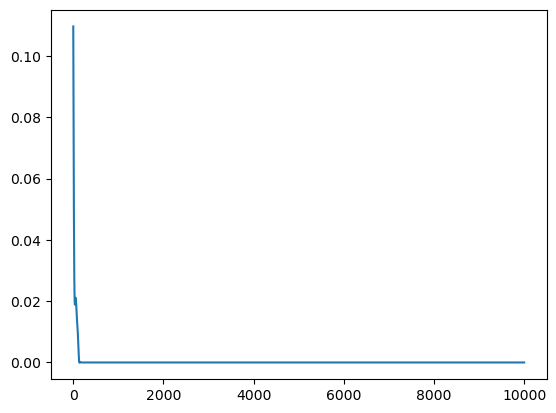

In [423]:
# Plot the test loss values
plt.plot(hist)

In [424]:
# Test out the loss
with torch.inference_mode():
    y_test_pred = model_0(x_test)
    test_loss = loss_fn(y_test, y_test_pred)

y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())
test_loss

tensor(2.0534e-07, device='cuda:0')

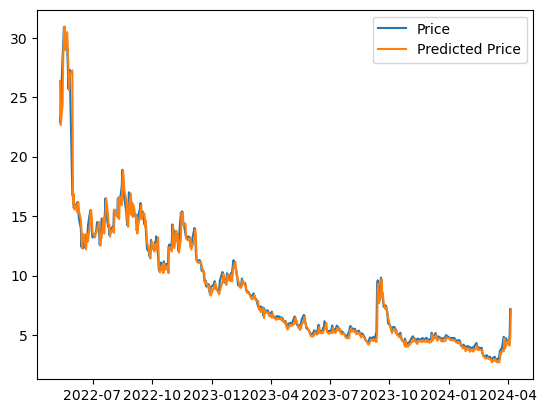

In [425]:
# Plot the predicted price to the actual price
plt.plot(data[len(data) - len(y_test):].index, y_test, label="Price")
plt.plot(data[len(data) - len(y_test):].index, y_test_pred, label="Predicted Price")
plt.legend()

array([[6.168751]], dtype=float32)

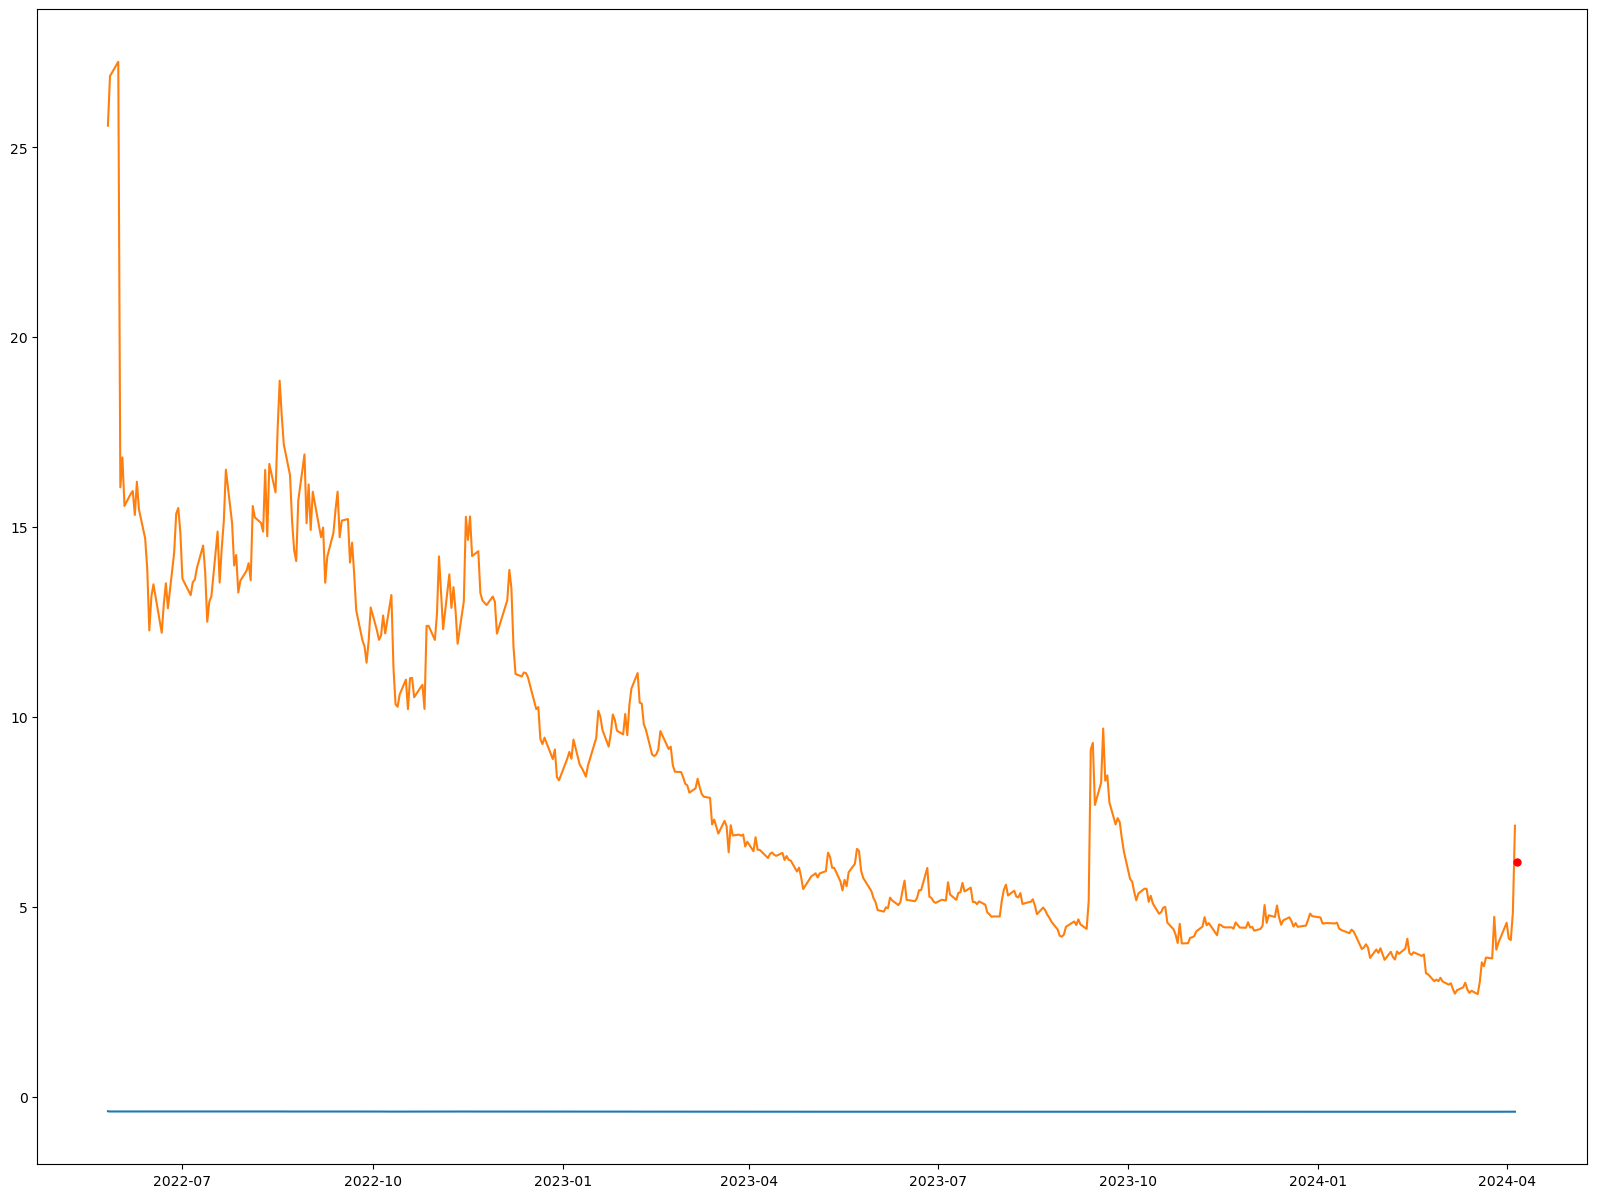

In [426]:
# Get the last sequence of data
last_sequence = data.values[-SEQUENCE_LENGTH:]
last_sequence = last_sequence.reshape((1, SEQUENCE_LENGTH, 1))
last_sequence = torch.from_numpy(last_sequence).type(torch.Tensor).to(device=device)

# Predict it using that sequence
with torch.inference_mode():
    model_0.eval()
    predicted_value = model_0(last_sequence)

predicted_value = scaler.inverse_transform(predicted_value.detach().cpu().numpy())

# This is how many days of data will be shown on the graph, so if this number
# is smaller the graph will be more zoomed in
NUMBER_OF_DAYS_OF_DATA = 10

# Plot the data
plt.figure(figsize=(20, 15))
plt.plot(data[len(data) - len(y_test) + NUMBER_OF_DAYS_OF_DATA:].index, data[data_to_predict][len(data) - len(y_test) + NUMBER_OF_DAYS_OF_DATA:])
plt.plot(data[len(data) - len(y_test) + NUMBER_OF_DAYS_OF_DATA:].index, y_test_pred[NUMBER_OF_DAYS_OF_DATA:])

next_day = data.index[-1] + pd.DateOffset(1)

plt.plot([next_day], predicted_value[0], marker='o', markersize=5, color='red')
predicted_value